In [1]:
# cancer tumor data TCGA-PANCAN-HiSeq-801x20531
# data website
# https://archive-beta.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq
# load the data from csv files
import pandas as pd
import numpy as np

# load the data from csv files
data = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)
# labels are different types of tumors
labels = pd.read_csv('labels.csv').drop('Unnamed: 0', axis=1)


In [2]:

print(np.unique(labels['Class']))
print(labels.shape)
print(data.shape)

['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']
(801, 1)
(801, 20531)


In [3]:
data.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


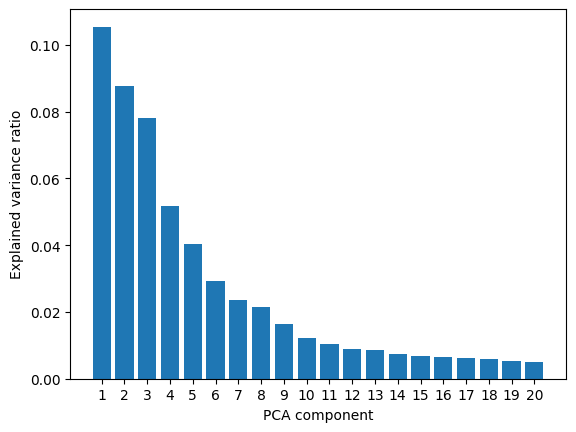

In [4]:
# PCA analysis for 10 components

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# standardize the data
data_scaled = StandardScaler().fit_transform(data)

# PCA analysis
pca = PCA(n_components=20)
pca.fit(data_scaled)
tumor_data = pca.transform(data_scaled)

# create a bar plot of the explained variance for each component
plt.bar(range(1,21), pca.explained_variance_ratio_)
plt.xlabel('PCA component')
plt.ylabel('Explained variance ratio')
# set the x ticks with the names of the components
plt.xticks(range(1,21))
plt.show()




We are now interested in different immunoreactive antigens, that is, one observation is the list of responses to one antigen. Therefore we transpose our tables. For visualization (and further computations) we map the tables using the first two principal components (`n_components=2`) obtained from Principal Component Analysis (PCA)

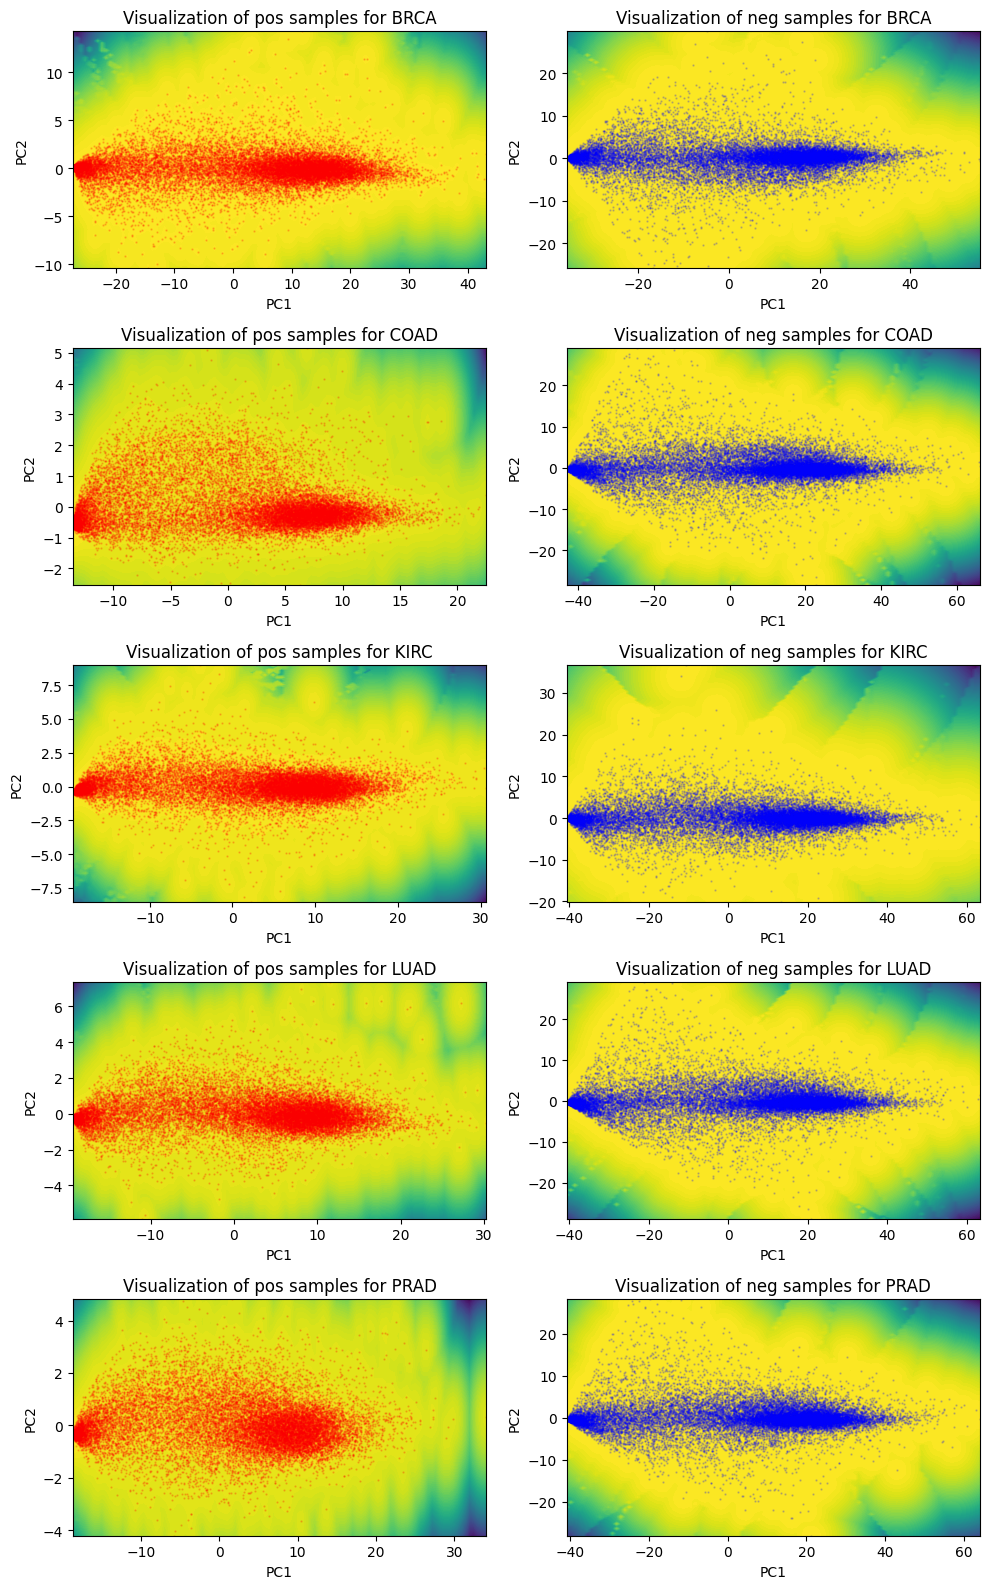

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

tumors = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']
fig, axs = plt.subplots(len(tumors), 2, figsize=(10, 16))  # Set the figure size

tumor_data = pd.DataFrame(data)
tumor_data['Class'] = labels

for i, t in enumerate(tumors):  
    ax_pos = axs[i, 0]  
    ax_neg = axs[i, 1]  
    
    tumor_data = pd.DataFrame(data)
    tumor_data['Class'] = labels
    tumor_data['Class'] = tumor_data['Class'].apply(lambda x: 1 if x == t else 0)

    tumor_pos = tumor_data[tumor_data['Class'] == 1].drop('Class', axis=1)
    tumor_neg = tumor_data[tumor_data['Class'] == 0].drop('Class', axis=1)

    tumor_posT = tumor_pos.T
    tumor_negT = tumor_neg.T

    # standardize the data
    tumor_posT_std = StandardScaler().fit_transform(tumor_posT)
    tumor_negT_std = StandardScaler().fit_transform(tumor_negT)

    pca_infected = PCA(n_components=2)
    pos2D = pca_infected.fit_transform(tumor_posT_std)

    pca_noninfected = PCA(n_components=2)
    neg2D = pca_noninfected.fit_transform(tumor_negT_std)

    desc = list(tumor_posT.index)

    def visualizePCA(ax, x, y, names, ttl, names_offset=0.1, c="r"):
        ax.set_title(ttl)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        kde = KernelDensity(bandwidth=0.3)  # Adjust the bandwidth as per your preference
        kde.fit(np.column_stack((x, y)))
        x_d, y_d = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
        z = kde.score_samples(np.column_stack((x_d.ravel(), y_d.ravel())))
        ax.contourf(x_d, y_d, z.reshape(x_d.shape), levels=100)
        ax.scatter(x, y, c=c, s=0.5, alpha=0.2)

    visualizePCA(ax_pos, pos2D[:, 0], pos2D[:, 1], desc, f"Visualization of pos samples for {t}", c="r",)
    visualizePCA(ax_neg, neg2D[:, 0], neg2D[:, 1], desc, f"Visualization of neg samples for {t}", c="b",)

plt.tight_layout()
plt.show()



In [41]:
# grid search with svc
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# standardize the data
data_scaled = StandardScaler().fit_transform(data)
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.2, random_state=42)

In [40]:
# grid search for the best parameters
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1]}
grid = GridSearchCV(SVC(), param_grid, verbose=3)
grid.fit(X_train, y_train.values.ravel())

# print the best parameters
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

# Results (took 8 minutes to run)
#   {'C': 10, 'gamma': 0.0001}
#   SVC(C=10, gamma=0.0001)
#   0.9515625
#   0.9627329192546584

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...............C=0.1, gamma=0.0001;, score=0.625 total time=   4.7s
[CV 2/5] END ...............C=0.1, gamma=0.0001;, score=0.609 total time=   4.5s
[CV 3/5] END ...............C=0.1, gamma=0.0001;, score=0.633 total time=   5.0s
[CV 4/5] END ...............C=0.1, gamma=0.0001;, score=0.562 total time=   4.7s
[CV 5/5] END ...............C=0.1, gamma=0.0001;, score=0.633 total time=   4.7s
[CV 1/5] END ................C=0.1, gamma=0.001;, score=0.375 total time=   5.1s
[CV 2/5] END ................C=0.1, gamma=0.001;, score=0.375 total time=   5.0s
[CV 3/5] END ................C=0.1, gamma=0.001;, score=0.375 total time=   5.3s
[CV 4/5] END ................C=0.1, gamma=0.001;, score=0.375 total time=   5.1s
[CV 5/5] END ................C=0.1, gamma=0.001;, score=0.367 total time=   5.2s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.375 total time=   5.4s
[CV 2/5] END .................C=0.1, gamma=0.01

2 11815061.447641619
3 10977532.720098287
4 10231596.265139226
5 9735047.350583136
6 9378693.448364733
7 9142227.706721764
8 8994492.762177771
9 8859253.045477733
10 8731733.637572547


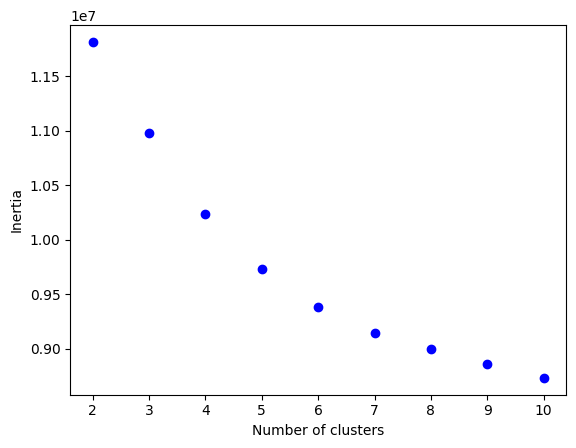

In [44]:
# kmeans clustering
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# standardize the data
data_scaled = StandardScaler().fit_transform(data)

for n in range(2, 11):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_train)
    print(n, kmeans.inertia_)
    plt.plot(n, kmeans.inertia_, 'bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

